In [51]:
from keras.utils import HDF5Matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.utils import to_categorical
from keras import backend as K
from keras.layers import Input, Dense, BatchNormalization, Dropout, Conv2D, MaxPool2D, Flatten, LeakyReLU, Concatenate, UpSampling2D
from IPython.display import Image

import keras
import tensorflow.compat.v1 as tf
import numpy as np
import pandas as pd
import imageio
import cv2

import pprint


import src.model as my_model
import src.pcam_loader as data
import src.adaptive_model as am

# Show if tensorflow can run with GPU
# Run tensorflow keras on multiple core

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# config = tf.ConfigProto(device_count={"CPU": 8})
# tensorflow.compat.v1.keras.backend.set_session(tf.Session(config=config))
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 554293951874153267
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4854028697
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7473368364681308226
physical_device_desc: "device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:26:00.0, compute capability: 7.5"
]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:26:00.0, compute capability: 7.5



## Load pcam data

In [3]:
# Load data from /User/Username/.keras/datasets/pcam
dataset = data.load_data()
x_train, y_train, meta_train =  dataset[0]
x_valid, y_valid, meta_valid =  dataset[1]
x_test, y_test, meta_test =  dataset[2]

C:\Users\matho\anaconda3\lib\site-packages\keras\utils\io_utils.py:60: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(datapath)


In [4]:
y_train = np.array(y_train[:])
y_train = y_train.reshape(-1, 1)
y_valid = np.array(y_valid[:])
y_valid = y_valid.reshape(-1, 1)
y_test = np.array(y_test[:])
y_test = y_test.reshape(-1, 1)

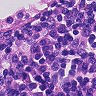

In [5]:
# Save data into png format and visualize image
# imageio.imwrite('image.png', )
Image(filename='./data/image.png') 

In [6]:
print(meta_train.head(5), '\n')
print(meta_train.info())

# Shape of train, valid and test input are the same, don't need to preprocess
print('\n' + 'Shape of train', x_train.shape,  len(y_train), y_train.shape)
print('Shape of valid', x_valid.shape,  len(y_valid), y_valid.shape)
print('Shape of test', x_test.shape, len(y_test), y_test.shape)


   Unnamed: 0  coord_y  coord_x  tumor_patch  center_tumor_patch  \
0           0    63104    43648        False               False   
1           1   148544    74048         True                True   
2           2    64192    78912         True                True   
3           3    98048    72128         True                True   
4           4    27264    50688        False               False   

                           wsi  
0   camelyon16_train_tumor_104  
1   camelyon16_train_tumor_003  
2   camelyon16_train_tumor_089  
3   camelyon16_train_tumor_004  
4  camelyon16_train_normal_118   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262144 entries, 0 to 262143
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Unnamed: 0          262144 non-null  int64 
 1   coord_y             262144 non-null  int64 
 2   coord_x             262144 non-null  int64 
 3   tumor_patch         262144 non-

## Build model

In [7]:
batch_size = 64
epochs = 10
num_classes = 2
shape = (96, 96, 3)

In [8]:
# Model with 3CNN 2(3,3)1(5,5) droupout accurancy 74,9%
# Model with 3CNN 2(3,3) droupout accurancy 73% on test 50%
# Model without droupout and 3CNN accurancy 72,29%
# Model with 5CNNN droupout accurany 63%
# Model with 5CNN 2(3,3)2(5,5) droupout accurancy %
# Model with 2CNN 16(3,3)32(3,3) accurancy 74,6%
# Model with 2CNN 64(3,3)64(3,3) accurancy 74,6%
# Simple CNN with 5 Convolutional layers and 2 Full connected layers, dropout

# input_layer = Input(shape=shape)

# conv1 = Conv2D(128, (3, 3), padding='same', activation='linear')(input_layer)
# conv1 = LeakyReLU(alpha=0.1)(conv1)
# conv1 = MaxPool2D((2, 2))(conv1)
# conv1 = Dropout(0.25)(conv1)

# conv2 = Conv2D(256, (3, 3), padding='same', activation='linear')(conv1)
# conv2 = LeakyReLU(alpha=0.1)(conv2)
# conv2 = MaxPool2D((2, 2))(conv2)
# conv2 = Dropout(0.25)(conv2)

# conv3 = Conv2D(512, (3, 3), padding='same', activation='linear')(conv2)
# conv3 = LeakyReLU(alpha=0.1)(conv3)
# conv3 = MaxPool2D((2, 2))(conv3)
# conv3 = Dropout(0.25)(conv3)

# conv4 = Conv2D(64, (5, 5), padding='same', activation='linear')(conv3)
# conv4 = LeakyReLU(alpha=0.1)(conv4)
# conv4 = MaxPool2D((2, 2))(conv4)
# conv4 = Dropout(0.25)(conv4)

# conv5 = Conv2D(64, (7, 7), padding='same', activation='linear')(conv4)
# conv5 = LeakyReLU(alpha=0.1)(conv5)
# conv5 = MaxPool2D((2, 2))(conv5)
# conv5 = Dropout(0.25)(conv5)

# dense = Flatten()(conv5)
# dense = Dense(128, activation='linear')(dense)
# dense = LeakyReLU(alpha=0.1)(dense)
# # dense = Dense(128, activation='linear')(dense)
# # dense = LeakyReLU(alpha=0.1)(dense)

# output = Dense(num_classes, activation='softmax')(dense)

# model = Model(input=[input_layer], output=[output])


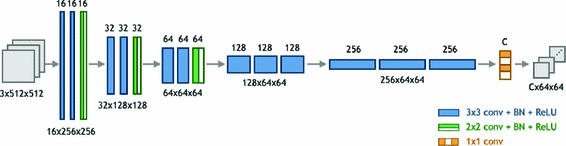

In [9]:
# Model CNN1 accurancy 73% on test on valid 90%
# Model CNN1 with one per layer dropout 66% on valid 90%
# Model CNN1 with droupout per convolutional layer 71% on valid 89%
# model = my_model.cnn1(shape, num_classes)
Image(filename='./data/cnn1.png')

# VGG 16 with 13 CNN on valid 50% on test 50%
# from 
# model = my_model.vgg_16(shape, 2)

# Unet with 9 convolution layer accurancy on test 80% on valid 96%
# from https://github.com/hlamba28/UNET-TGS/blob/master/TGS%20UNET.ipynb
# model = my_model.get_unet(shape)

In [76]:
def gabor_filter(shape, dtype=None):
    filters = []
    kernels = []
    ksize = shape[0]
    for theta in np.arange(0, np.pi, np.pi / shape[3]):
        params = {'ksize':(ksize, ksize), 'sigma':1.0, 'theta':theta, 'lambd':15.0,
                  'gamma':0.02, 'psi':0, 'ktype':cv2.CV_32F}
        kernel = cv2.getGaborKernel(**params)
        kernel /= 1.5*kernel.sum()
        
        kernels.append(kernel)
        print(kernels[0])
            
#     first_shape = []
#     for first in kernels:
#         second_shape = []
#         for second in first:
#             third_shape = []
#             for third in range(color_channels):
#                 fourth_shape = []
#                 for fourth in range(shape[3]):
#                         fourth_shape.append(second)
#                 print(fourth_shape)
#                 third_shape.append(fourth_shape)
#             second_shape.append(third_shape)
#         first_shape.append(second_shape)
#     reshaped_kernel = np.array(first_shape)
#     filters.append(reshaped_kernel)
    first_shape = []
    for first in range(len(kernels[0])):
        for second in range(len(kernels[0][first])):
            print(kernels[0][first][second])
    
    print('Needed shape is', shape, reshaped_kernel.shape)
    return K.variable(filters, dtype='float32')

#     f = np.array([
#             [[[1],[1],[1]], [[0],[0],[0]], [[-1],[-1],[-1]]],
#             [[[1],[1],[1]], [[0],[0],[0]], [[-1],[-1],[-1]]],
#             [[[1],[1],[1]], [[0],[0],[0]], [[-1],[-1],[-1]]]
#         ])

weight_filler {type: "gabor"}
def gabor_layer(layer):
    layer = Conv2D(filters=1, kernel_size = 3, kernel_initializer=gabor_filter, strides=2, padding='valid')(layer)
    return layer

gabor_layer(am.input_layer(shape))

TypeError: ('Keyword argument not understood:', 'weight_filler')

In [ ]:
# Input layer with shape of data
input_layer = am.input_layer(shape)

## Define first layer as Gabor, BackPropagation(unet) and AutoEncoder(encoder)
# layers = am.unet_layer(input_layer) # 78,8% on test
# layers = am.encoder_concatenate_layer(input_layer) # on valid 96,97% on test 67%
# layers = am.encoder_multiple_upsampling_layer(input_layer) # on test 74,% on valid 97,7%
layers = gabor_layer(input_layer)

# Use Unet architecture as main model
output_layer = am.unet_model(input_layer)

# Define model 
model = am.define_model(input_layer, output_layer)

### Compile and train the model

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adam(),metrics=['accuracy', 'cosine_proximity'])

model.summary()

In [ ]:
model.fit(
    x_train,
    to_categorical(y_train),
    # batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_valid, to_categorical(y_valid)),
    shuffle='batch',
    # Add multiprocessing and workers
    use_multiprocessing=True, 
    workers=8
)

In [ ]:
model.save('adaptive_model_ECL.h5')

In [ ]:
from keras.models import load_model
model = load_model('adaptive_model_ECL.h5')

In [ ]:
test_eval = model.evaluate(x_test, to_categorical(y_test), verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])
